# About the Competition

## SIIM-ISIC Melanoma Classification
### Identify melanoma in lesion images

Skin cancer is the most prevalent type of cancer. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by data science—can make treatment more effective.

Currently, dermatologists evaluate every one of a patient's moles to identify outlier lesions or “ugly ducklings” that are most likely to be melanoma. Existing AI approaches have not adequately considered this clinical frame of reference. Dermatologists could enhance their diagnostic accuracy if detection algorithms take into account “contextual” images within the same patient to determine which images represent a melanoma. If successful, classifiers would be more accurate and could better support dermatological clinic work.

As the leading healthcare organization for informatics in medical imaging, the Society for Imaging Informatics in Medicine (SIIM)'s mission is to advance medical imaging informatics through education, research, and innovation in a multi-disciplinary community. SIIM is joined by the International Skin Imaging Collaboration (ISIC), an international effort to improve melanoma diagnosis. The ISIC Archive contains the largest publicly available collection of quality-controlled dermoscopic images of skin lesions.

In this competition, you’ll identify melanoma in images of skin lesions. In particular, you’ll use images within the same patient and determine which are likely to represent a melanoma. Using patient-level contextual information may help the development of image analysis tools, which could better support clinical dermatologists.

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.

# Important findings <a class="anchor" id="findings"></a>

* **We can clearly observe groups of images with similar statistics that depend on the image shapes!!!**
* **There is one group of the test images that is missing in train(1080 rows 1920 columns)! This would mean a complete new type of images that may lead to notable differences in CV scores and LB!**
* For most of the patients there were only a few images recorded (range from 1 to 20).
* 5% of the patients show more than 45 images. There is an extreme outlier in the test data with roughly 250 images!
* We have more males than females in both train and test data. For the test set this imbalance is even higher!
* We can observe **more older patients in test than in train**! The age is normally distributed in train but shows multiple modes in test.
* The distributions of image locations look very similar for train and test.
* We have highly imbalanced target classes!
* Multiple images does not mean that there are multiple ages involved! 
* We can observe a high surplus of males in the ages 45 to 50 and 70, 75 in train and test but in test we can find **even more males of high age > 75**.
* We have more malignant cases of higher age than benign cases.
* 62 % of the malignant cases belong to males and only 38 % to females! **We have to be very careful!!! As we have a surpus of males with ages above 70 and 75 it's unclear if the sex is really an important feature for having melanoma or not.** It could also be that the age is most important and that we only have more malignant cases for males due to their higher age! 

## Upload Necessary Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
import seaborn as sns
sns.set()

import re

import pydicom
import random

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

#import pytorch_lightning as pl
from scipy.special import softmax

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, auc

from skimage.io import imread
from PIL import Image

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import os
import copy

from albumentations import Compose, RandomCrop, Normalize,HorizontalFlip, Resize
from albumentations import VerticalFlip, RGBShift, RandomBrightness
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch import ToTensor

from tqdm.notebook import tqdm

os.listdir("../input/")

['melanoma-256x256',
 'melanoma-512x512',
 'isic2019-768x768',
 'melanoma-128x128',
 'isic2019-256x256',
 'pytorch-pretrained-image-models',
 'melanoma-768x768',
 'siimisic-melanoma-resized-images',
 'isic2019-384x384',
 'jpeg-melanoma-128x128',
 'isic2019-512x512',
 'melanoma-384x384',
 'siimisic-melanoma-classification-image-stats',
 'isic2019-128x128',
 'siim-isic-melanoma-classification',
 'melanomaclassificationsmoothiestarter',
 'melanoma-external-malignant-256',
 'melanoma-192x192',
 'isic2019-192x192']

In [2]:
basepath = "../input/siim-isic-melanoma-classification/"
modelspath = "../input/pytorch-pretrained-image-models/"
imagestatspath = "../input/siimisic-melanoma-classification-image-stats/"

In [3]:
os.listdir(basepath)

['test.csv',
 'train',
 'jpeg',
 'sample_submission.csv',
 'train.csv',
 'tfrecords',
 'test']

In [4]:
train_info = pd.read_csv(basepath + "train.csv")
train_info.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [5]:
test_info = pd.read_csv(basepath + "test.csv")
test_info.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

Our test set misses three columns: diagnosis, benign_malignant & target.

In [6]:
train_info.shape[0] / test_info.shape[0]

3.0163904571116373

Three times more entries in train than in test.

# What is given by the meta data? 

## Missing values

In [7]:
missing_vals_train = train_info.isnull().sum() / train_info.shape[0]
missing_vals_train[missing_vals_train > 0].sort_values(ascending=False)

anatom_site_general_challenge    0.015909
age_approx                       0.002053
sex                              0.001962
dtype: float64

In [8]:
missing_vals_test = test_info.isnull().sum() / test_info.shape[0]
missing_vals_test[missing_vals_test > 0].sort_values(ascending=False)

anatom_site_general_challenge    0.031961
dtype: float64

The anatomy shows most missing values. 

## Image names

In [9]:
train_info.image_name.value_counts().max()

1

In [10]:
test_info.image_name.value_counts().max()

1

### Patient id counts

In [11]:
train_info.patient_id.value_counts().max()

115

In [12]:
test_info.patient_id.value_counts().max()

240

In contrast we can find multiple images for one patient!

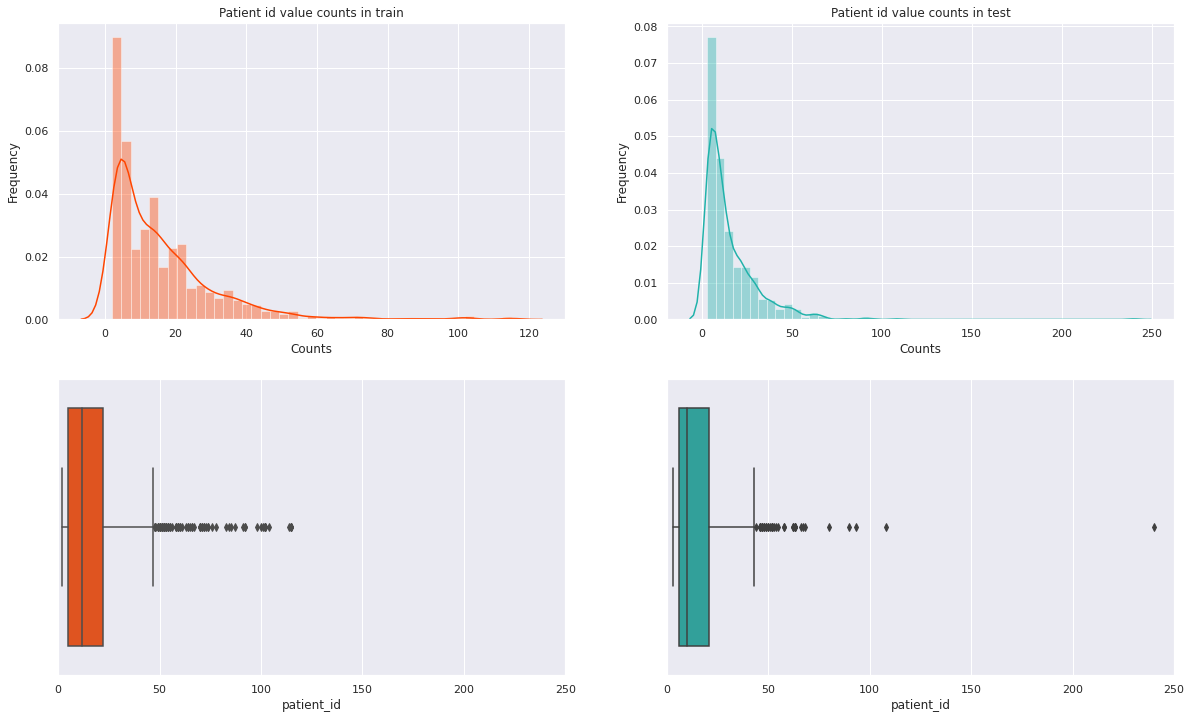

In [13]:
patient_counts_train = train_info.patient_id.value_counts()
patient_counts_test = test_info.patient_id.value_counts()

fig, ax = plt.subplots(2,2,figsize=(20,12))

sns.distplot(patient_counts_train, ax=ax[0,0], color="orangered", kde=True);
ax[0,0].set_xlabel("Counts")
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_title("Patient id value counts in train");

sns.distplot(patient_counts_test, ax=ax[0,1], color="lightseagreen", kde=True);
ax[0,1].set_xlabel("Counts")
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_title("Patient id value counts in test");

sns.boxplot(patient_counts_train, ax=ax[1,0], color="orangered");
ax[1,0].set_xlim(0, 250)
sns.boxplot(patient_counts_test, ax=ax[1,1], color="lightseagreen");
ax[1,1].set_xlim(0, 250);

In [14]:
np.quantile(patient_counts_train, 0.75) - np.quantile(patient_counts_train, 0.25)

17.0

In [15]:
np.quantile(patient_counts_train, 0.5)

12.0

In [16]:
print(np.quantile(patient_counts_train, 0.95))
print(np.quantile(patient_counts_test, 0.95))

44.25
46.549999999999955


### Insights

* For most of the patients we only have a few images ranging fom 1 to roughly 20.
* More than 45 images per patient is very seldom! 
* Nonetheless we have patients with more than 100 images.
* There is one heavy outlier patient in the test set with close to 250 images.

In [17]:
200/test_info.shape[0] * 100

1.821161901293025

## Overlapping patients in train/test

In [18]:
train_patient_ids = set(train_info.patient_id.unique())
test_patient_ids = set(test_info.patient_id.unique())

train_patient_ids.intersection(test_patient_ids)

set()

Ok, that's great! There seem to be no patients in train that can be found in test as well. We can't be sure as we don't know how the naming assignment process was designed. We might better check the images themselves as well!

## Gender counts

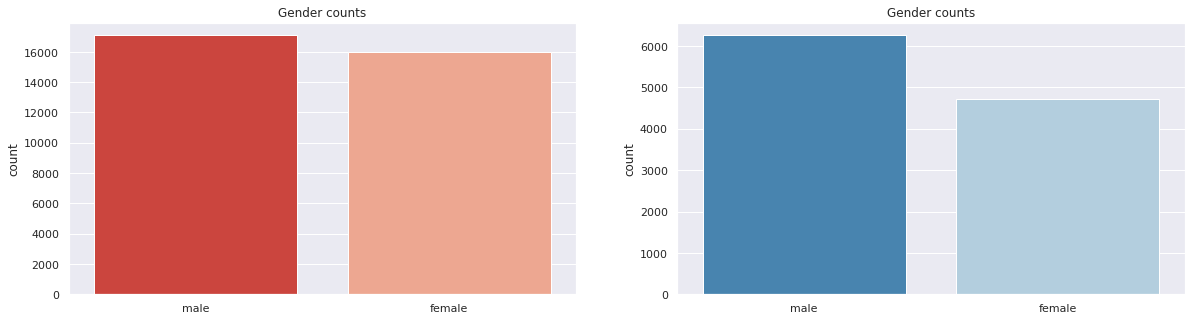

In [19]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train_info.sex, palette="Reds_r", ax=ax[0]);
ax[0].set_xlabel("")
ax[0].set_title("Gender counts");

sns.countplot(test_info.sex, palette="Blues_r", ax=ax[1]);
ax[1].set_xlabel("")
ax[1].set_title("Gender counts");

### Insights

* We observe more males than females in both train and test data.
* The surplus of males is even higher in test than in train!

### Age distributions

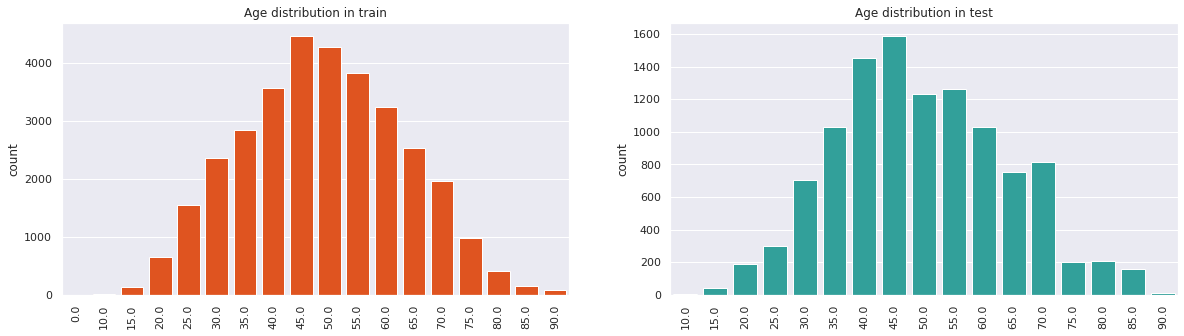

In [20]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(train_info.age_approx, color="orangered", ax=ax[0]);
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_xlabel("");
ax[0].set_title("Age distribution in train");

sns.countplot(test_info.age_approx, color="lightseagreen", ax=ax[1]);
labels = ax[1].get_xticklabels();
ax[1].set_xticklabels(labels, rotation=90);
ax[1].set_xlabel("");
ax[1].set_title("Age distribution in test");

# Image Recognition

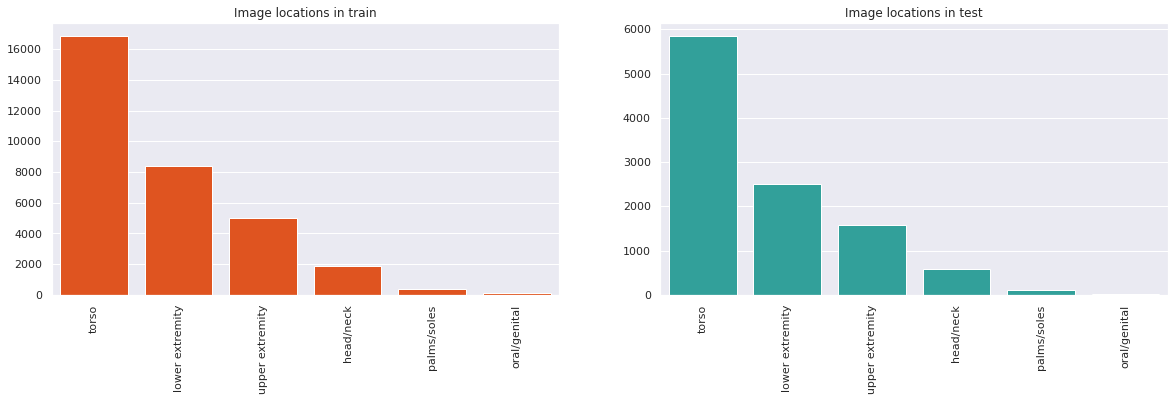

In [21]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

image_locations_train = train_info.anatom_site_general_challenge.value_counts().sort_values(ascending=False)
image_locations_test = test_info.anatom_site_general_challenge.value_counts().sort_values(ascending=False)

sns.barplot(x=image_locations_train.index.values, y=image_locations_train.values, ax=ax[0], color="orangered");
ax[0].set_xlabel("");
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_title("Image locations in train");

sns.barplot(x=image_locations_test.index.values, y=image_locations_test.values, ax=ax[1], color="lightseagreen");
ax[1].set_xlabel("");
labels = ax[1].get_xticklabels();
ax[1].set_xticklabels(labels, rotation=90);
ax[1].set_title("Image locations in test");

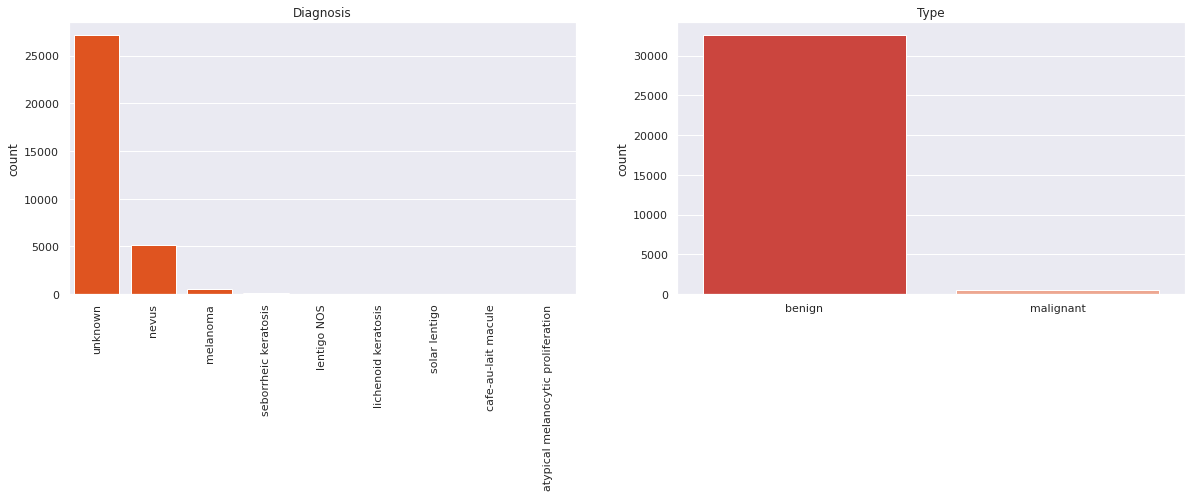

In [22]:
# Target distribution
fig, ax = plt.subplots(1,2, figsize=(20,5))

sns.countplot(x=train_info.diagnosis, orient="v", ax=ax[0], color="Orangered")
ax[0].set_xlabel("")
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_title("Diagnosis");

sns.countplot(train_info.benign_malignant, ax=ax[1], palette="Reds_r");
ax[1].set_xlabel("")
ax[1].set_title("Type");

In [23]:
# Training Data Grouped by benign_malignant
train_info.groupby("benign_malignant").target.nunique()

benign_malignant
benign       1
malignant    1
Name: target, dtype: int64

## Feature Selection

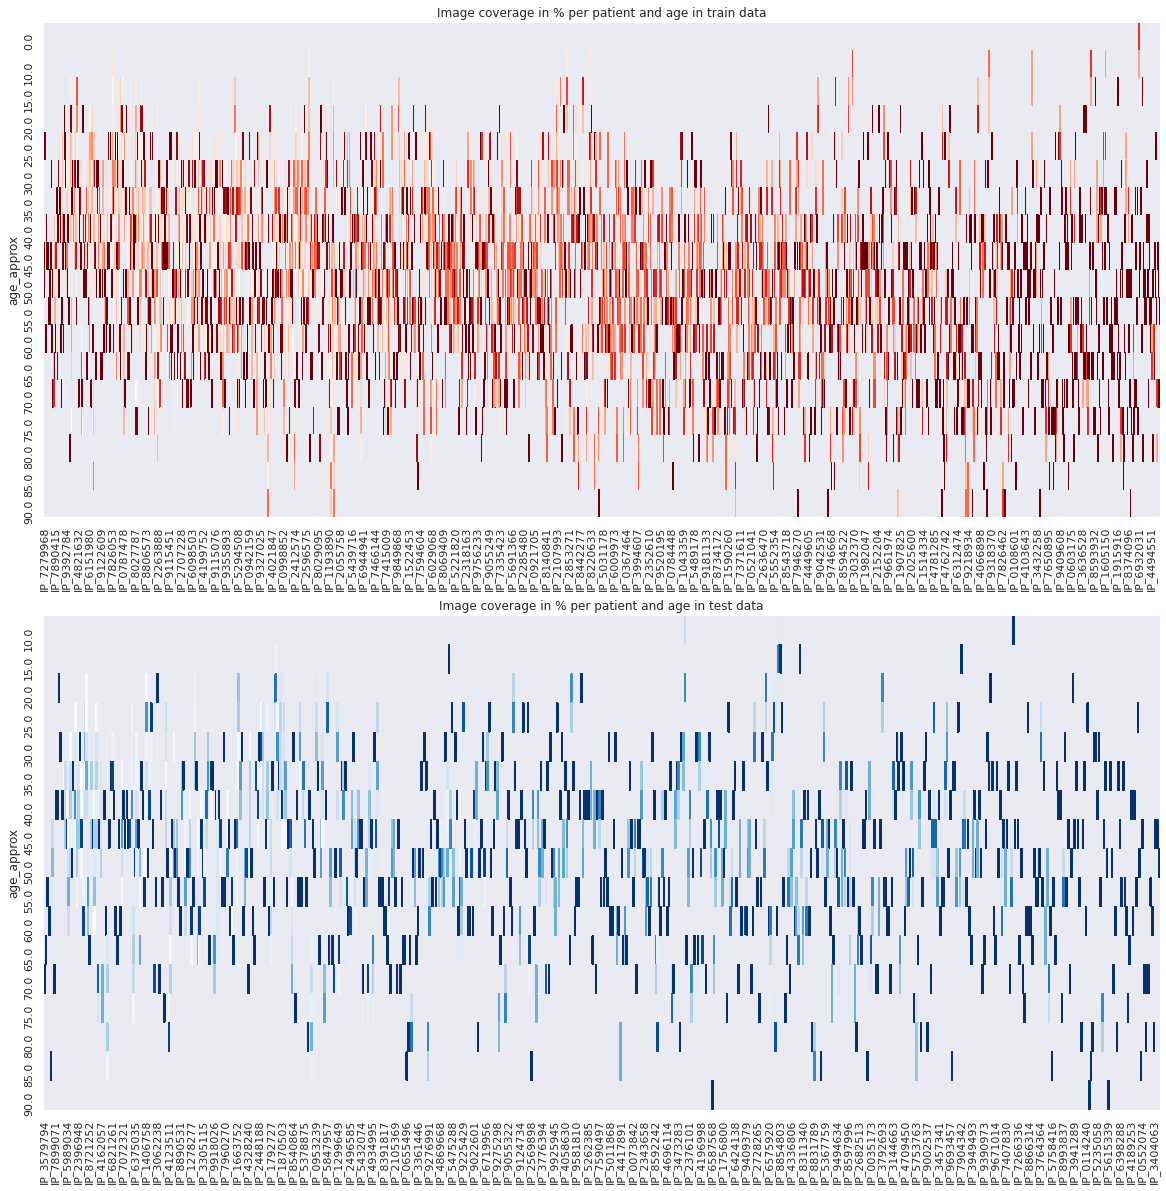

In [24]:
patient_ages_table_train = train_info.groupby(["patient_id", "age_approx"]).size() / train_info.groupby("patient_id").size()
patient_ages_table_train = patient_ages_table_train.unstack().transpose()
patient_ages_table_test = test_info.groupby(["patient_id", "age_approx"]).size() / test_info.groupby("patient_id").size()
patient_ages_table_test = patient_ages_table_test.unstack().transpose()

patient_with_known_ages_train = train_info[train_info.patient_id.isin(patient_ages_table_train.columns.values)]

sorted_patients_train = patient_with_known_ages_train.patient_id.value_counts().index.values
patient_with_known_ages_test = test_info[test_info.patient_id.isin(patient_ages_table_test.columns.values)]
sorted_patients_test = patient_with_known_ages_test.patient_id.value_counts().index.values

fig, ax = plt.subplots(2,1, figsize=(20,20))
sns.heatmap(patient_ages_table_train[sorted_patients_train], cmap="Reds", ax=ax[0], cbar=False);
ax[0].set_title("Image coverage in % per patient and age in train data");
sns.heatmap(patient_ages_table_test[sorted_patients_test], cmap="Blues", ax=ax[1], cbar=False);
ax[1].set_title("Image coverage in % per patient and age in test data");
ax[0].set_xlabel("")
ax[1].set_xlabel("");

### Data Visualization Age Vs. Gender

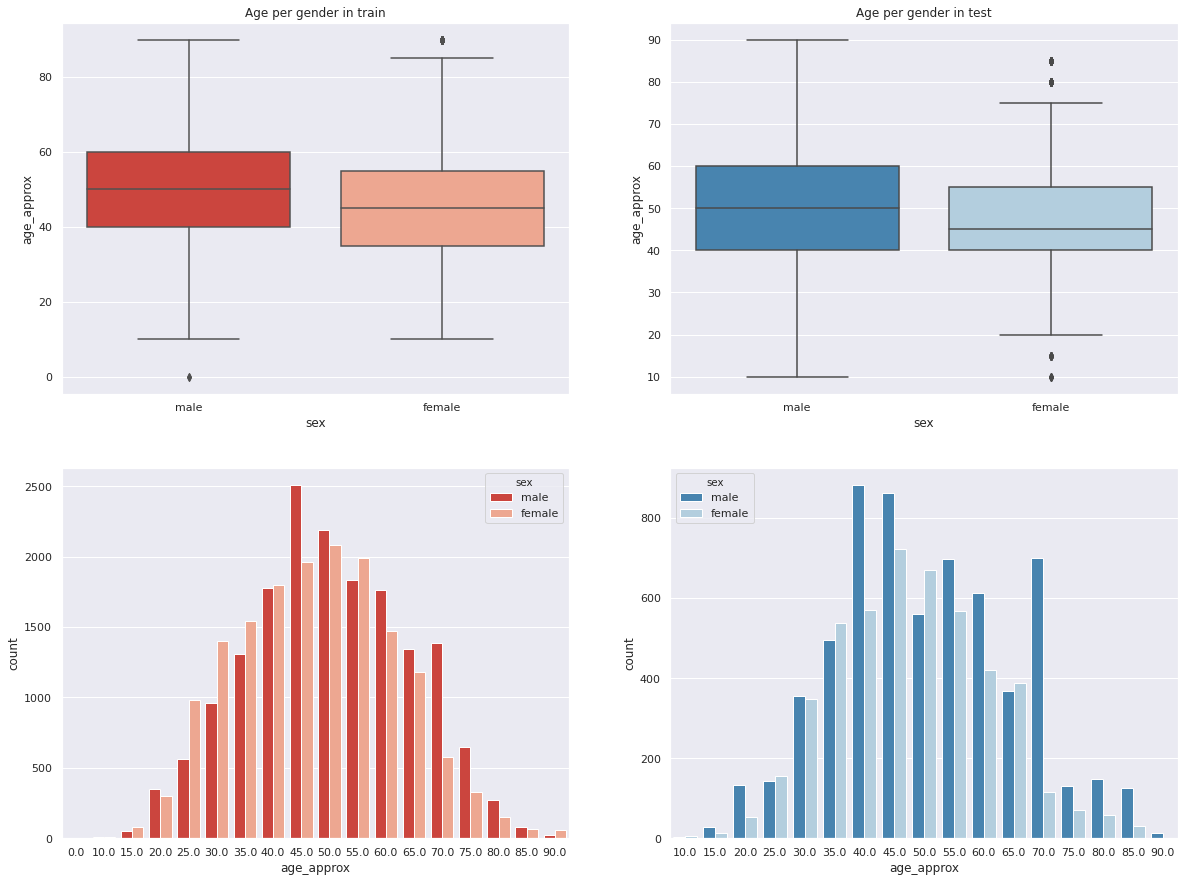

In [25]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.boxplot(train_info.sex, train_info.age_approx, ax=ax[0,0], palette="Reds_r");
ax[0,0].set_title("Age per gender in train");

sns.boxplot(test_info.sex, test_info.age_approx, ax=ax[0,1], palette="Blues_r");
ax[0,1].set_title("Age per gender in test");

sns.countplot(train_info.age_approx, hue=train_info.sex, ax=ax[1,0], palette="Reds_r");
sns.countplot(test_info.age_approx, hue=test_info.sex, ax=ax[1,1], palette="Blues_r");

## Gender, Age Vs. Cancer

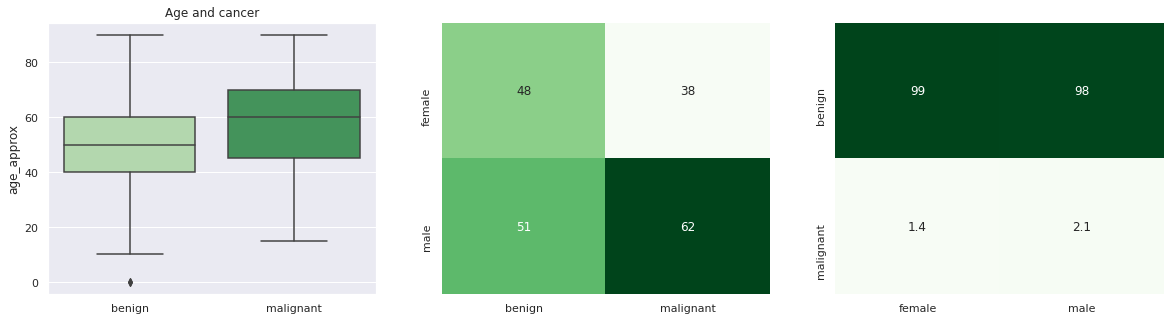

In [26]:
sex_and_cancer_map = train_info.groupby(
    ["benign_malignant", "sex"]
).size().unstack(level=0) / train_info.groupby("benign_malignant").size() * 100

cancer_sex_map = train_info.groupby(
    ["benign_malignant", "sex"]
).size().unstack(level=1) / train_info.groupby("sex").size() * 100


fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.boxplot(train_info.benign_malignant, train_info.age_approx, ax=ax[0], palette="Greens");
ax[0].set_title("Age and cancer");
ax[0].set_xlabel("");

sns.heatmap(sex_and_cancer_map, annot=True, cmap="Greens", cbar=False, ax=ax[1])
ax[1].set_xlabel("")
ax[1].set_ylabel("");

sns.heatmap(cancer_sex_map, annot=True, cmap="Greens", cbar=False, ax=ax[2])
ax[2].set_xlabel("")
ax[2].set_ylabel("");

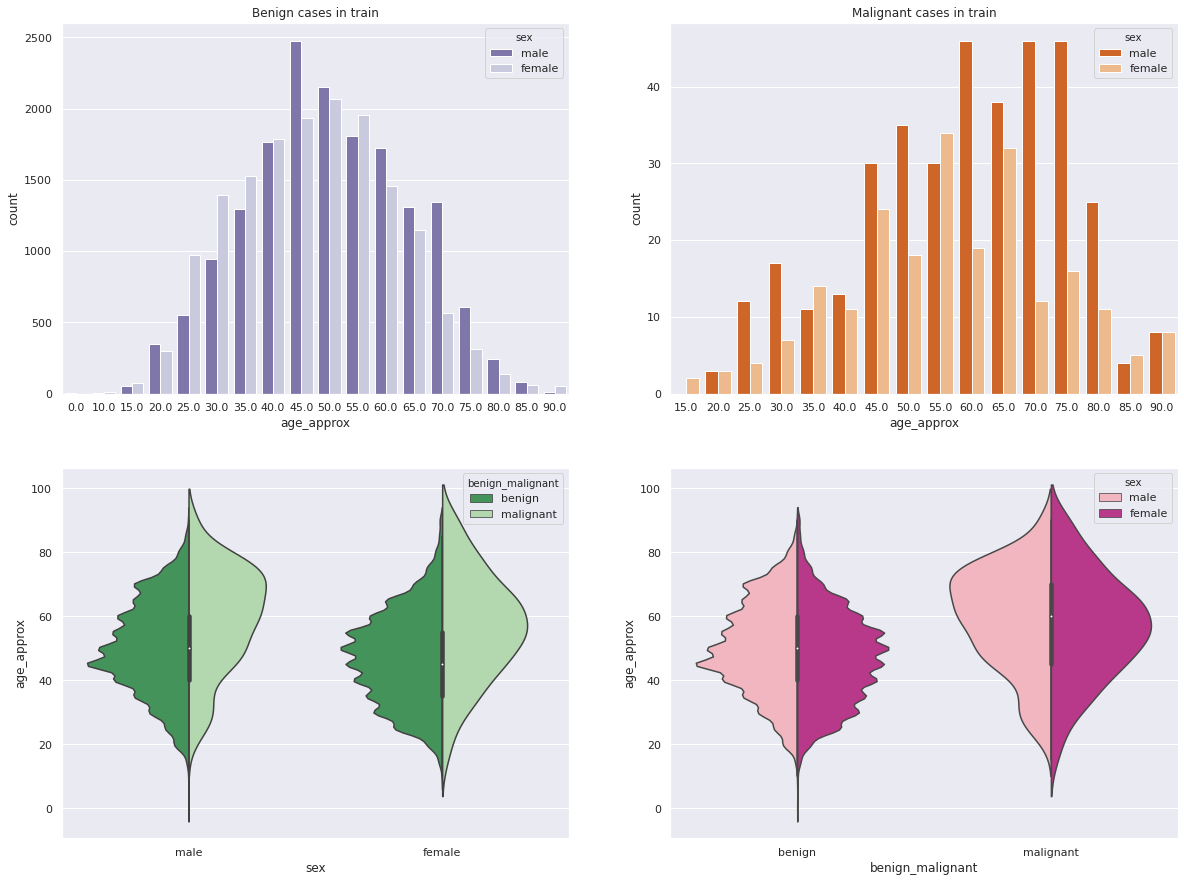

In [27]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.countplot(train_info[train_info.benign_malignant=="benign"].age_approx, hue=train_info.sex, palette="Purples_r", ax=ax[0,0])
ax[0,0].set_title("Benign cases in train");

sns.countplot(train_info[train_info.benign_malignant=="malignant"].age_approx, hue=train_info.sex, palette="Oranges_r", ax=ax[0,1])
ax[0,1].set_title("Malignant cases in train");

sns.violinplot(train_info.sex, train_info.age_approx, hue=train_info.benign_malignant, split=True, ax=ax[1,0], palette="Greens_r");
sns.violinplot(train_info.benign_malignant, train_info.age_approx, hue=train_info.sex, split=True, ax=ax[1,1], palette="RdPu");

## Patient Information Management Individually

In [28]:
patient_gender_train = train_info.groupby("patient_id").sex.unique().apply(lambda l: l[0])
patient_gender_test = test_info.groupby("patient_id").sex.unique().apply(lambda l: l[0])

train_patients = pd.DataFrame(index=patient_gender_train.index.values, data=patient_gender_train.values, columns=["sex"])
test_patients = pd.DataFrame(index=patient_gender_test.index.values, data=patient_gender_test.values, columns=["sex"])

train_patients.loc[:, "num_images"] = train_info.groupby("patient_id").size()
test_patients.loc[:, "num_images"] = test_info.groupby("patient_id").size()

train_patients.loc[:, "min_age"] = train_info.groupby("patient_id").age_approx.min()
train_patients.loc[:, "max_age"] = train_info.groupby("patient_id").age_approx.max()
test_patients.loc[:, "min_age"] = test_info.groupby("patient_id").age_approx.min()
test_patients.loc[:, "max_age"] = test_info.groupby("patient_id").age_approx.max()

train_patients.loc[:, "age_span"] = train_patients["max_age"] - train_patients["min_age"]
test_patients.loc[:, "age_span"] = test_patients["max_age"] - test_patients["min_age"]

train_patients.loc[:, "benign_cases"] = train_info.groupby(["patient_id", "benign_malignant"]).size().loc[:, "benign"]
train_patients.loc[:, "malignant_cases"] = train_info.groupby(["patient_id", "benign_malignant"]).size().loc[:, "malignant"]
train_patients["min_age_malignant"] = train_info.groupby(["patient_id", "benign_malignant"]).age_approx.min().loc[:, "malignant"]
train_patients["max_age_malignant"] = train_info.groupby(["patient_id", "benign_malignant"]).age_approx.max().loc[:, "malignant"]

In [29]:
train_patients.sort_values(by="malignant_cases", ascending=False).head()

sex  num_images  min_age  max_age  age_span  benign_cases  \
IP_7373371  female          42     55.0     60.0       5.0          34.0   
IP_9111321    male          13     60.0     60.0       0.0           7.0   
IP_2412574    male          23     65.0     70.0       5.0          18.0   
IP_3237442    male           8     65.0     85.0      20.0           3.0   
IP_9037179    male           7     70.0     75.0       5.0           3.0   

            malignant_cases  min_age_malignant  max_age_malignant  
IP_7373371              8.0               55.0               60.0  
IP_9111321              6.0               60.0               60.0  
IP_2412574              5.0               65.0               70.0  
IP_3237442              5.0               65.0               80.0  
IP_9037179              4.0               70.0               70.0

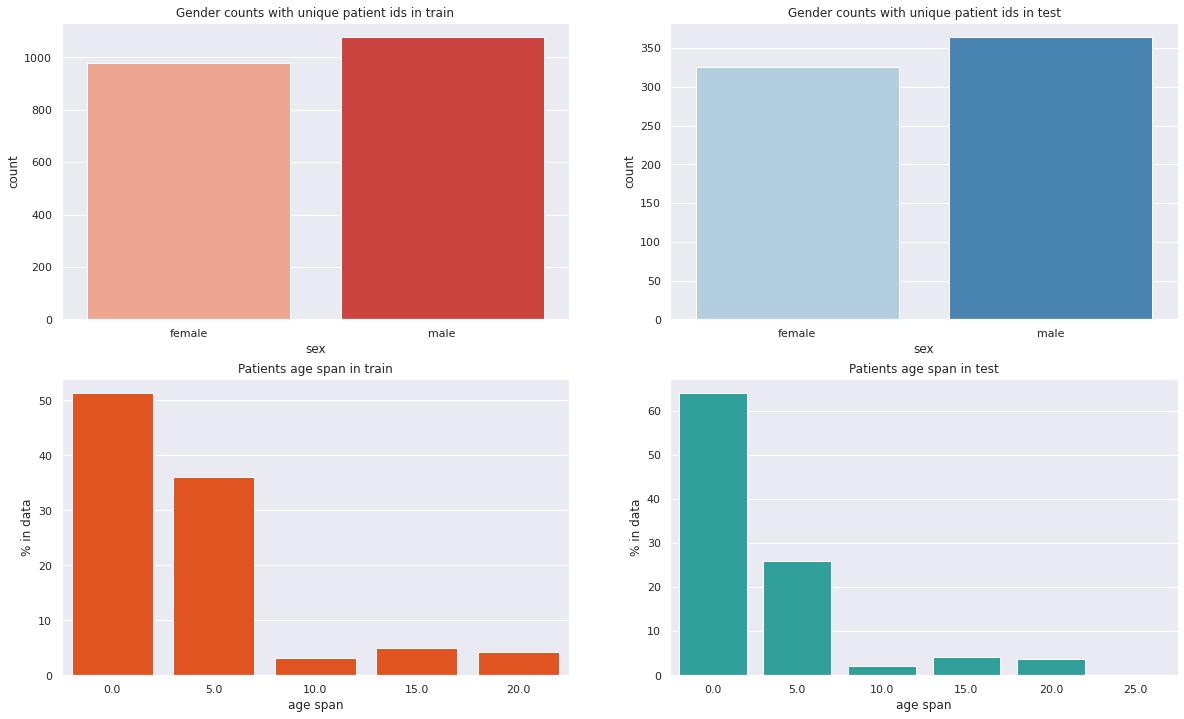

In [30]:
fig, ax = plt.subplots(2,2,figsize=(20,12))
sns.countplot(train_patients.sex, ax=ax[0,0], palette="Reds")
ax[0,0].set_title("Gender counts with unique patient ids in train")
sns.countplot(test_patients.sex, ax=ax[0,1], palette="Blues");
ax[0,1].set_title("Gender counts with unique patient ids in test");

train_age_span_perc = train_patients.age_span.value_counts() / train_patients.shape[0] * 100
test_age_span_perc = test_patients.age_span.value_counts() / test_patients.shape[0] * 100

sns.barplot(train_age_span_perc.index, train_age_span_perc.values, ax=ax[1,0], color="Orangered");
sns.barplot(test_age_span_perc.index, test_age_span_perc.values, ax=ax[1,1], color="Lightseagreen");
ax[1,0].set_title("Patients age span in train")
ax[1,1].set_title("Patients age span in test")
for n in range(2):
    ax[1,n].set_ylabel("% in data")
    ax[1,n].set_xlabel("age span");

## Different between Train and Test set Image

In [31]:
example_files = os.listdir(basepath + "train/")[0:2]
example_files

['ISIC_6977092.dcm', 'ISIC_2673608.dcm']

In [32]:
train_info.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [33]:
train_info["dcm_path"] = basepath + "train/" + train_info.image_name + ".dcm"
test_info["dcm_path"] = basepath + "test/" + test_info.image_name + ".dcm"

In [34]:
print(train_info.dcm_path[0])
print(test_info.dcm_path[0])

../input/siim-isic-melanoma-classification/train/ISIC_2637011.dcm
../input/siim-isic-melanoma-classification/test/ISIC_0052060.dcm


In [35]:
example_dcm = pydicom.dcmread(train_info.dcm_path[2])
example_dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7623.4154.1589900259084.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 

In [36]:
image = example_dcm.pixel_array
print(image.shape)

(1053, 1872, 3)


In [37]:
train_info["image_path"] = basepath + "jpeg/train/" + train_info.image_name + ".jpg"
test_info["image_path"] = basepath + "jpeg/test/" + test_info.image_name + ".jpg"

### Exploratory Data Analysis

In [38]:
os.listdir(imagestatspath)

['train_image_stats_10000.csv',
 'train_image_stats_toend.csv',
 'train_stats_and_meta.csv',
 'test_stats_and_meta.csv',
 'test_image_stats.csv',
 'train_image_stats_complete.csv',
 'train_image_stats_20000.csv']

In [39]:
test_image_stats = pd.read_csv(imagestatspath +  "test_image_stats.csv")
test_image_stats.head(1)

path  rows  columns  channels  \
0  ../input/siim-isic-melanoma-classification/tes...  4000     6000         3   

     img_mean    img_std  img_skew  red_mean  green_mean  blue_mean  
0  152.848088  32.890196  0.506357       NaN         NaN        NaN

In [40]:
train_image_stats_1 = pd.read_csv(imagestatspath + "train_image_stats_10000.csv")
train_image_stats_2 = pd.read_csv(imagestatspath + "train_image_stats_20000.csv")
train_image_stats_3 = pd.read_csv(imagestatspath + "train_image_stats_toend.csv")
train_image_stats_4 = train_image_stats_1.append(train_image_stats_2)
train_image_stats = train_image_stats_4.append(train_image_stats_3)
train_image_stats.shape

(33126, 10)

### Statistical Analysis

In [41]:
plot_test = True

In [42]:
if plot_test:
    N = test_image_stats.shape[0]
    selected_data = test_image_stats
    my_title = "Test image statistics"
else:
    N = train_image_stats.shape[0]
    selected_data = train_image_stats
    my_title = "Train image statistics"

trace1 = go.Scatter3d(
    x=selected_data.img_mean.values[0:N], 
    y=selected_data.img_std.values[0:N],
    z=selected_data.img_skew.values[0:N],
    mode='markers',
    text=selected_data["rows"].values[0:N],
    marker=dict(
        color=selected_data["columns"].values[0:N],
        colorscale = "Jet",
        colorbar=dict(thickness=10, title="image columns", len=0.8),
        opacity=0.4,
        size=2
    )
)


In [43]:
figure_data = [trace1]
layout = go.Layout(
    title = my_title,
    scene = dict(
        xaxis = dict(title="Image mean"),
        yaxis = dict(title="Image standard deviation"),
        zaxis = dict(title="Image skewness"),
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    showlegend=True
)

fig = go.Figure(data=figure_data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [44]:
test_image_stats.groupby(["rows", "columns"]).size().sort_values(ascending=False).iloc[0:10] / test_image_stats.shape[0]

rows  columns
4000  6000       0.378984
1053  1872       0.187671
1080  1920       0.156256
480   640        0.111455
3456  5184       0.066381
2448  3264       0.043981
1936  2592       0.024130
2848  4288       0.018121
576   768        0.004826
3024  4032       0.001275
dtype: float64

In [45]:
train_image_stats.groupby(["rows", "columns"]).size().sort_values(ascending=False).iloc[0:10] / train_image_stats.shape[0]

rows  columns
4000  6000       0.443851
1053  1872       0.227435
480   640        0.125189
3456  5184       0.103182
2448  3264       0.044768
2848  4288       0.022007
1936  2592       0.020347
2592  3888       0.004226
3024  4032       0.002536
2317  2317       0.000875
dtype: float64

In [46]:
examples1 = {"rows": 1080, "columns": 1920}
examples2 = {"rows": 4000, "columns": 6000}

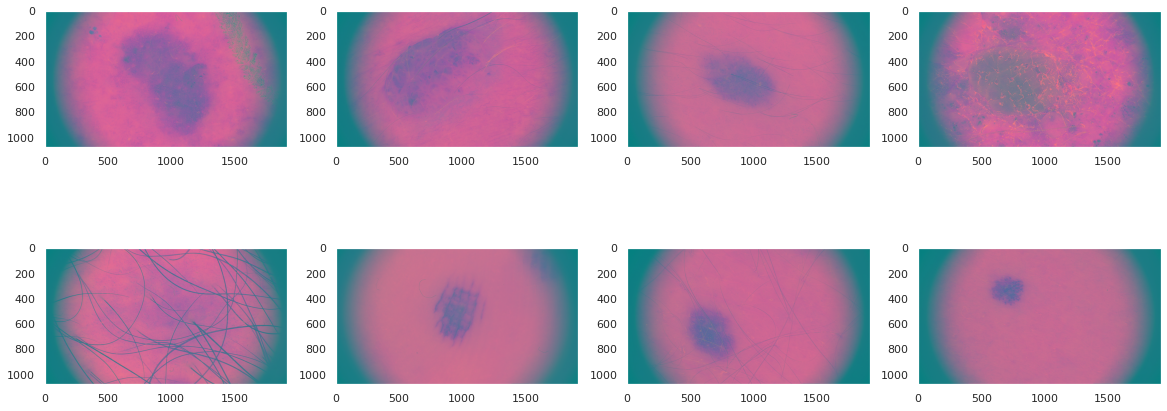

In [47]:
selection1 = np.random.choice(test_image_stats[
    (test_image_stats["rows"]==examples1["rows"]) & (test_image_stats["columns"]==examples1["columns"])
].path.values, size=8, replace=False)

fig, ax = plt.subplots(2,4,figsize=(20,8))

for n in range(2):
    for m in range(4):
        path = selection1[m + n*4]
        dcm_file = pydicom.dcmread(path)
        image = dcm_file.pixel_array
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

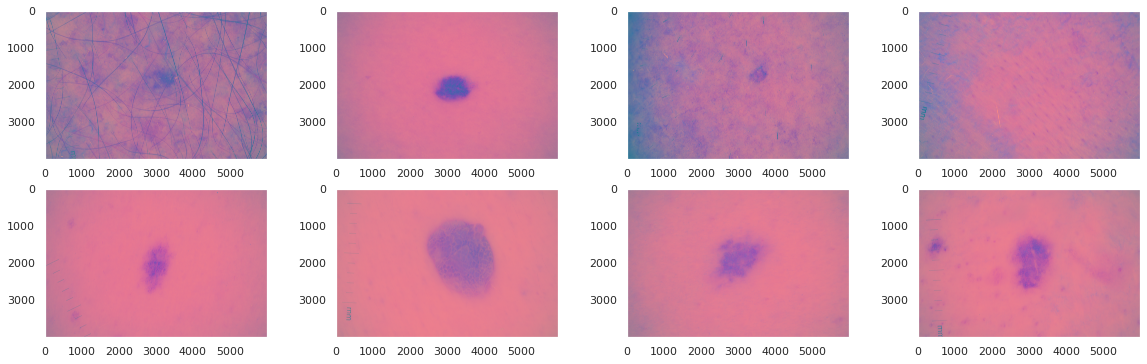

In [48]:
selection2 = np.random.choice(test_image_stats[
    (test_image_stats["rows"]==examples2["rows"]) & (test_image_stats["columns"]==examples2["columns"])
].path.values, size=8, replace=False)

fig, ax = plt.subplots(2,4,figsize=(20,6))

for n in range(2):
    for m in range(4):
        path = selection2[m + n*4]
        dcm_file = pydicom.dcmread(path)
        image = dcm_file.pixel_array
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

# Triple Stratified KFold CV with TFRecords
This is a simple starter notebook for Kaggle's Melanoma Comp showing triple stratifed KFold with TFRecords. Triple stratified KFold is explained [here][2]. There are many configuration variables below to allow you to experiment. Use either GPU or TPU. You can control which size images are loaded, which efficientNets are used, and whether external data is used. You can experiment with different data augmentation, model architecture, loss, optimizers, and learning schedules. The TFRecords contain meta data, so you can input that into your CNN too. 

**NOTE:** this notebook lets you run a different experiment in each fold if you want to run lots of experiments. (Then it is like running multiple holdout validaiton experiments but in that case note that the overall CV score is meaningless because LB will be much higher when the multiple experiments are ensembled to predict test). **If you want a proper CV with a reliable overall CV score you need to choose the same configuration for each fold.**

This notebook follows the 5 step process presented in my "How to compete with GPUs Workshop" [here][1]. Some code sections have been reused from AgentAuers' great notebook [here][3]

[1]: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526
[3]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once

# Kaggle's SIIM-ISIC Melanoma Classification
In this competition, we need to identify melanoma in images of skin lesions. Full description [here][1]. This is a very challenging image classification task as seen by looking at the sample images below. Can you recognize the differences between images? Below are example of skin images with and without melanoma.

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification

Examples WITH Melanoma


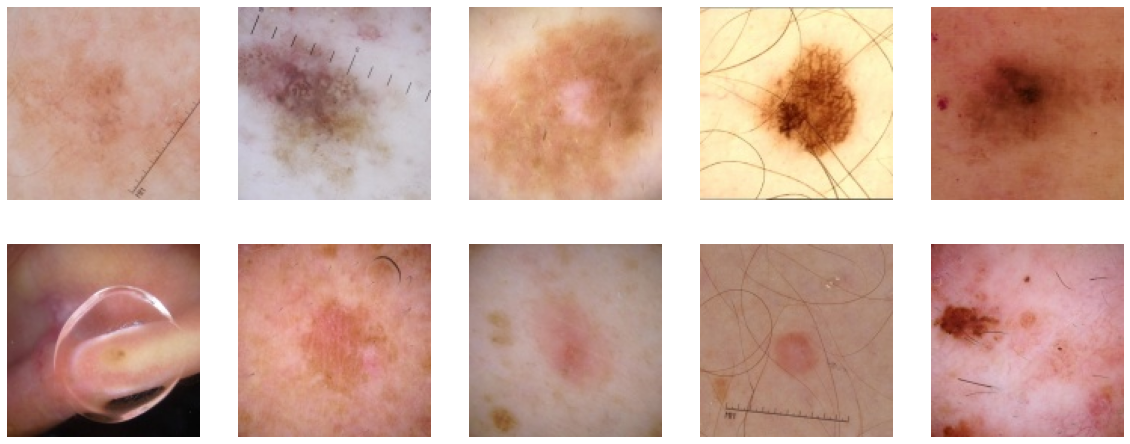

Examples WITHOUT Melanoma


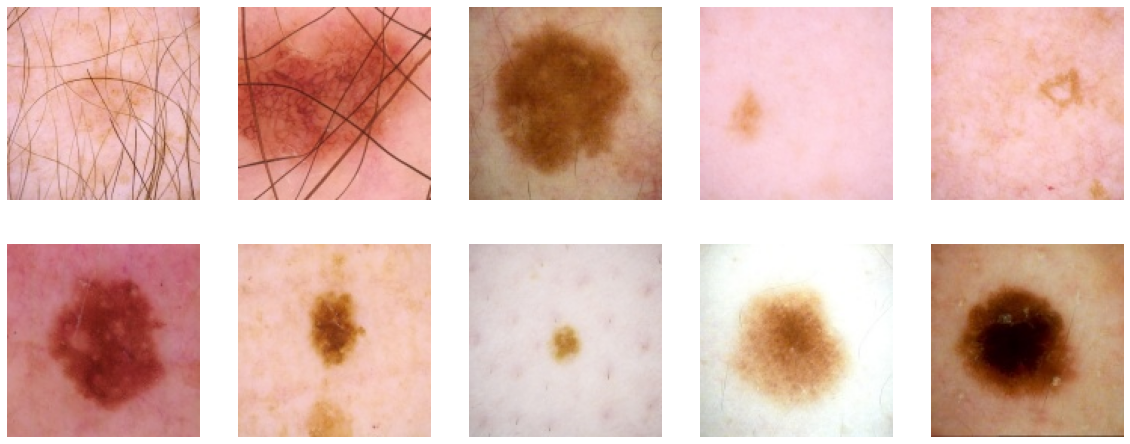

In [49]:
import cv2, pandas as pd, matplotlib.pyplot as plt
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
print('Examples WITH Melanoma')
imgs = train.loc[train.target==1].sample(10).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread('../input/jpeg-melanoma-128x128/train/%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()
print('Examples WITHOUT Melanoma')
imgs = train.loc[train.target==0].sample(10).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread('../input/jpeg-melanoma-128x128/train/%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()

In [50]:
!pip install -q efficientnet >> /dev/null

In [51]:
import pandas as pd, numpy as np
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

## Configuration
In order to be a proper cross validation with a meaningful overall CV score (aligned with LB score), **you need to choose the same** `IMG_SIZES`, `INC2019`, `INC2018`, and `EFF_NETS` **for each fold**. If your goal is to just run lots of experiments, then you can choose to have a different experiment in each fold. Then each fold is like a holdout validation experiment. When you find a configuration you like, you can use that configuration for all folds. 
* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
* IMG_SIZES - is a Python list of length FOLDS. These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - is a list of length FOLDS. These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - is a list of length FOLDS. These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter.
* EFF_NETS - is a list of length FOLDS. These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF during validation.

In [52]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [384,384,384,384,384]

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0,0,0,0,0]
INC2018 = [1,1,1,1,1]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*FOLDS
EPOCHS = [12]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [6,6,6,6,6]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

In [53]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


# Step 1: Preprocess
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 by changing the `IMG_SIZES` variable in the preceeding code section. These TFRecords are discussed [here][1]. The advantage of using different input sizes is discussed [here][2]

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155579
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147

In [54]:
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
    GCS_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

# Step 2: Data Augmentation
This notebook uses rotation, sheer, zoom, shift augmentation first shown in this notebook [here][1] and successfully used in Melanoma comp by AgentAuers [here][2]. This notebook also uses horizontal flip, hue, saturation, contrast, brightness augmentation similar to last years winner and also similar to AgentAuers' notebook.

Additionally we can decide to use external data by changing the variables `INC2019` and `INC2018` in the preceeding code section. These variables respectively indicate whether to load last year 2019 data and/or year 2018 + 2017 data. These datasets are discussed [here][3]

Consider experimenting with different augmenation and/or external data. The code to load TFRecords is taken from AgentAuers' notebook [here][2]. Thank you AgentAuers, this is great work.

[1]: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
[2]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
[3]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164910

In [55]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [56]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [57]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [58]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled:
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

# Step 3: Build Model
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN.

In [59]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

def build_model(dim=128, ef=0):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(1024, acivation = 'relu')(x)
#     x = tf.keras.layers.Dropout(0.4)(x)
#     x = tf.keras.layers.Dense(512, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2())(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2())(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

# Step 4: Train Schedule
This is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

In [60]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## Train Model
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

#########################
#### FOLD 1
#### Image Size 384 with EfficientNet B6 and batch_size 256
#### Using 2018+2017 external data
#########################
165527552/165527152 [==============================] - 2s 0us/step
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 1 OOF AUC without TTA = 0.915, with TTA = 0.929


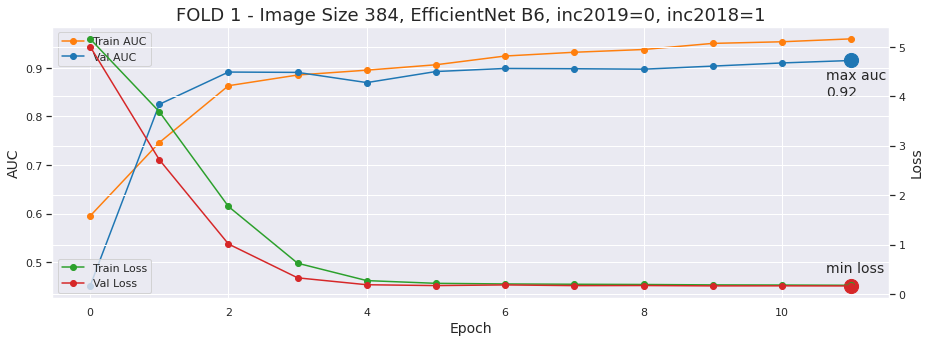

#########################
#### FOLD 2
#### Image Size 384 with EfficientNet B6 and batch_size 256
#### Using 2018+2017 external data
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 2 OOF AUC without TTA = 0.906, with TTA = 0.928


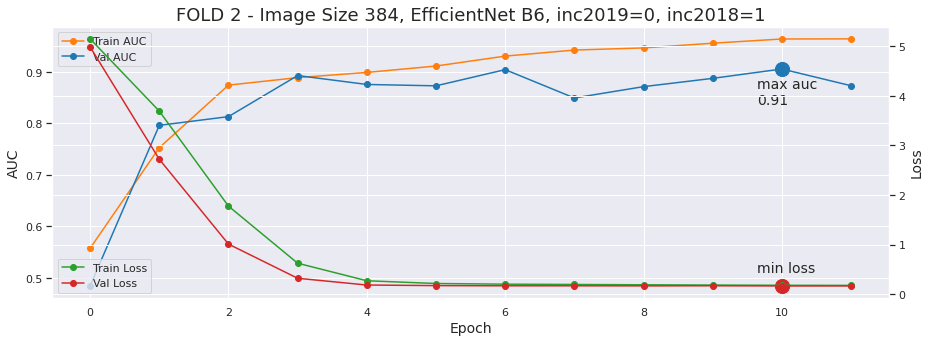

#########################
#### FOLD 3
#### Image Size 384 with EfficientNet B6 and batch_size 256
#### Using 2018+2017 external data
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 3 OOF AUC without TTA = 0.932, with TTA = 0.937


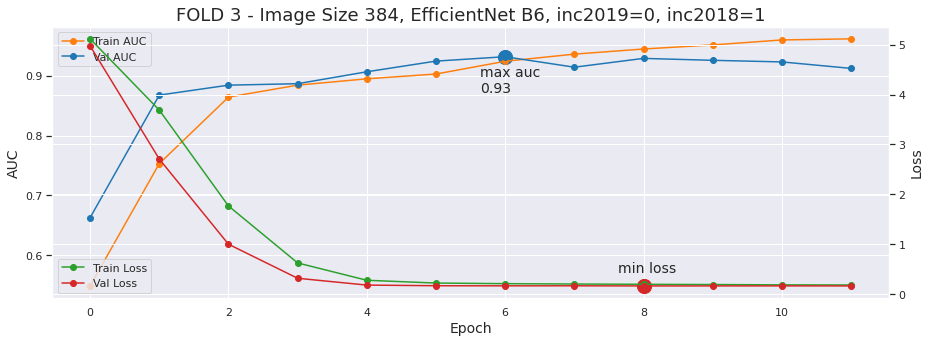

#########################
#### FOLD 4
#### Image Size 384 with EfficientNet B6 and batch_size 256
#### Using 2018+2017 external data
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 4 OOF AUC without TTA = 0.909, with TTA = 0.923


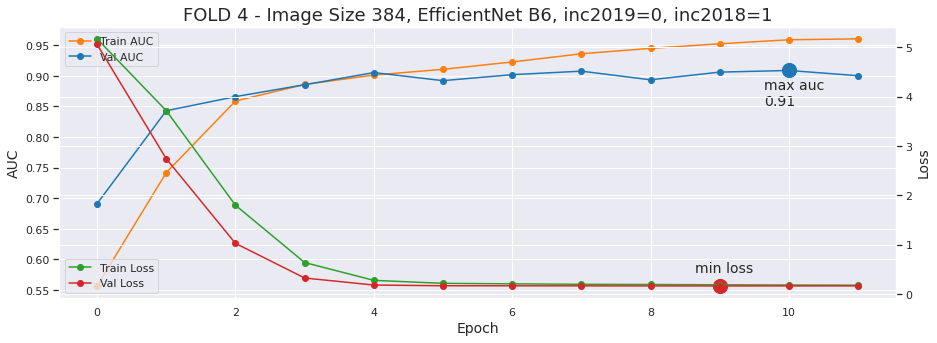

#########################
#### FOLD 5
#### Image Size 384 with EfficientNet B6 and batch_size 256
#### Using 2018+2017 external data
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 5 OOF AUC without TTA = 0.914, with TTA = 0.920


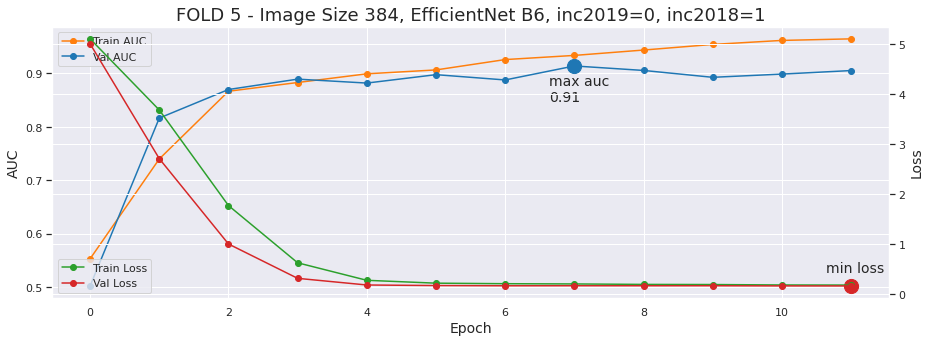

In [61]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 0
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
        epochs=EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), #class_weight = {0:1,1:2},
        verbose=VERBOSE
    )
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show()  

## Calculate OOF AUC
The OOF (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the OOF to determine what are the best weights to blend your models with. Choose weights that maximize OOF CV score when used to blend OOF. Then use those same weights to blend your test predictions.

In [62]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.923


image_name  target      pred  fold
0  ISIC_2637011       0  0.029422     0
1  ISIC_0076262       0  0.025709     0
2  ISIC_0074268       0  0.022048     0
3  ISIC_0015719       0  0.023838     0
4  ISIC_0082543       0  0.026719     0

# Step 5: Post process
There are ways to modify predictions based on patient information to increase CV LB. You can experiment with that here on your OOF.

# Submit To Kaggle

In [63]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [64]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv('submission.csv', index=False)
submission.head()

image_name    target
9905  ISIC_0052060  0.025299
1443  ISIC_0052349  0.024119
3120  ISIC_0058510  0.023763
4870  ISIC_0073313  0.023796
5494  ISIC_0073502  0.026131

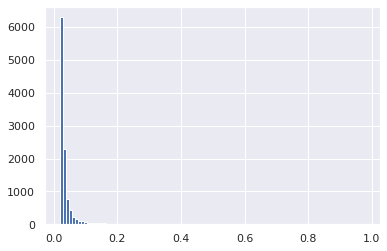

In [65]:
plt.hist(submission.target,bins=100)
plt.show()

## -------------------- End--------------------------